In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm

In [2]:
import random
import numpy as np
import os
import time
import json
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
train_path = 'train2014/'

val_path = 'val2014/'

train_annot_path = 'annotations/captions_train2014.json'
val_annot_path = 'annotations/captions_val2014.json'

In [ ]:
# load tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [11]:
# open test_data json 
with open('test_data.json', 'r') as f:
    test_data = json.load(f)

In [ ]:
# Transformer
# Restore from checkpoints

checkpoint_path = "./checkpoints/trans"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, 
                                          max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [67]:
# evaluate
def evaluate(image, max_length=21):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=(224, 224))
    image = tf.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) 
    result = [] 
 
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(image, output)
        predictions, attention_weights = transformer(image, output, False, enc_padding_mask,
                                       combined_mask, dec_padding_mask)
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)
 
    return result, tf.squeeze(output, axis=0), attention_weights

In [46]:
# clean test captions
for key, captions in test_data.items():   
    for i, caption in enumerate (captions):
        caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
        clean_words = [word for word in caption_nopunct.split()]
        clean_words = clean_words[1:-1]
        caption_new = ' '.join(clean_words)
        captions[i] = caption_new

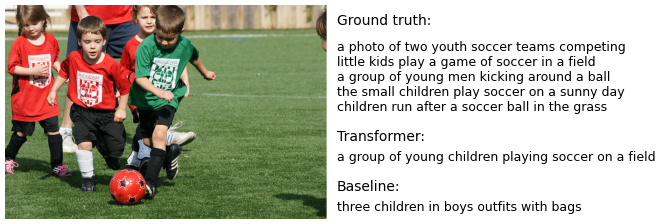

In [141]:
image = np.random.choice(test_keys)
caption, result, attention_weights = evaluate(image)
res_join = ' '.join(caption)
gt = test_data[image]

img = mpimg.imread(image)
h, w, _= np.shape(img)
img_plate=np.zeros((h, w + 150, 3), dtype=np.uint8) + 255
img_plate[0:h, 0:w, :] = img

dpi = 50
figsize = 0.8 * w / float(dpi), 0.8 * h / float(dpi)

fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.text(w + 20, 40, 'Ground truth:', fontsize=20)
ax.text(w + 20, 210, '\n'.join(gt), fontsize=18)

ax.text(w + 20, 270, 'Transformer:', fontsize=20)
ax.text(w + 20, 310, res_join, fontsize=18)

plt.axis('off')
plt.imshow(img_plate)

In [62]:
def generate_test_captions(test_images, max_length=21):
    captions = []
    for i, image in tqdm(enumerate(test_images)):
        captions.append(evaluate(image, max_length)[0])

    return captions

In [63]:
generated_captions = generate_test_captions(test_keys)

5000it [2:44:04,  1.97s/it]


In [ ]:
join_cap = [' '.join(i) for i in generated_captions]

In [66]:
pred_captions = []

for i, j in zip(test_keys, join_cap):
    pred_captions.append({"image_id": int(i[27:33]), "caption": j})

In [68]:
with open('pred_captions_trans.json', 'w') as fp:
    json.dump(pred_captions, fp)

In [ ]:
pip install pycocoevalcap

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')
import sys

input_json = sys.argv[1]


annFile = 'annotations/captions_val2014.json'
coco = COCO(annFile)
valids = coco.getImgIds()

load = json.load(open('pred_captions_trans.json', 'r'))

In [ ]:
# filter results to only those in MSCOCO validation set
preds_filt = [p for p in load if p['image_id'] in valids]
print('using %d/%d predictions' % (len(preds_filt), len(load)))
json.dump(preds_filt, open('tmp.json', 'w'))

In [72]:
cocoRes = coco.loadRes(preds_filt)
cocoEval = COCOEvalCap(coco, cocoRes)
cocoEval.params['image_id'] = cocoRes.getImgIds()
cocoEval.evaluate()

# create output dictionary
out = {}
for metric, score in cocoEval.eval.items():
    out[metric] = score

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 48152, 'reflen': 47865, 'guess': [48152, 43152, 38152, 33152], 'correct': [30236, 13369, 5431, 2391]}
ratio: 1.0059960305024338
Bleu_1: 0.628
Bleu_2: 0.441
Bleu_3: 0.303
Bleu_4: 0.211
computing METEOR score...
METEOR: 0.203
computing Rouge score...
ROUGE_L: 0.462
computing CIDEr score...
CIDEr: 0.647
computing SPICE score...
SPICE: 0.128
